In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from src.models.components.mlp import MyMLP

from torch.func import jacrev

import os
import copy

from src.models.components.noise_schedules import GeometricNoiseSchedule, LinearNoiseSchedule
from src.energies.base_prior import Prior

from torchdiffeq import odeint
from math import sqrt

device = torch.device('cuda')

### Functions

In [3]:
def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    # mins = -1 
    # maxs = 1
    mins = -10
    maxs = 10 
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    x = x * 2 - 1
    
    return x

def unnormalize(x, mins=-10, maxs=10):
    '''
        x : [ -1, 1 ]
    '''
    # assert x.max() <= 1 and x.min() >= -1, f'x range: ({x.min():.4f}, {x.max():.4f})'
    x = (x + 1) / 2
    return x * (maxs - mins) + mins

In [4]:
class VEReverseSDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule

    def f(self, t, x):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones_like(x).to(x.device)

        score = self.score(t[:,0], x)
        return self.g(t, x).pow(2) * score

    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g

In [5]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    drift = sde.f(t, x) * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones_like(x).to(device)
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, 1-t, dt)
            samples.append(x)
    return torch.stack(samples)

def generate_samples(reverse_sde, num_samples, t_span=(0, 1)):
    samples = prior.sample(num_samples)
    return integrate_sde(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=1e-2,
    )[-1]

### Pre-trained Diffusion

In [6]:
log_max = np.log(1 - 1e-6)
log_min = np.log(1e-6)
EPS = 1e-6

# Data Details

# prior_var = 2.0
gmm_var = 0.25 /100

# beta = torch.tensor(prior_var)
# noise_schedule = LinearNoiseSchedule(beta)

noise_schedule = GeometricNoiseSchedule(sigma_min=0.01, sigma_max=sqrt(2))

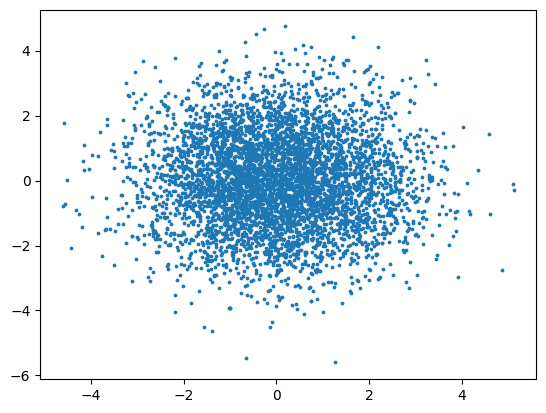

In [7]:
# prior = torch.distributions.Normal(torch.zeros(2).to(device),
#                                    noise_schedule.h(torch.tensor(1).to(device)),
#                                    validate_args=False)

prior = Prior(dim=2, device=device, scale = noise_schedule.h(1) ** 0.5)
x1_samples = prior.sample(5000).detach().cpu()
plt.scatter(x1_samples[:, 0], x1_samples[:, 1], s=3)

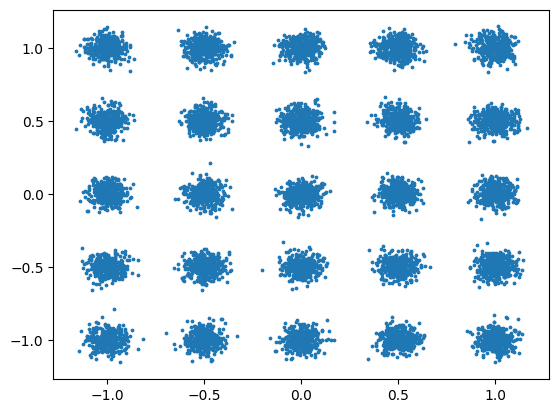

In [8]:
means = []
for i in range(5):
    for j in range(5):
        if 4-i > j:
            continue
        means.append([(i-2) * 5., (j-2) * 5.])

for i in range(5):
    for j in range(5):
        if 4-i <= j:
            continue
        means.append([(i-2) * 5., (j-2) * 5.])

means = torch.tensor(means).to(device)
means = means/10

mix = torch.distributions.Categorical(torch.ones(25,).to(device))
comp = torch.distributions.Independent(torch.distributions.Normal(loc=means,
                                                                  scale=gmm_var**0.5,
                                                                  validate_args=False), 1)
full_gmm = torch.distributions.MixtureSameFamily(mix, comp, validate_args=False)

samples = full_gmm.sample((10000,)) #.detach().cpu()
x0_samples = samples
normalized_samples = samples #normalize(samples)
plt.scatter(samples.detach().cpu()[:, 0], samples.detach().cpu()[:, 1], s=3)


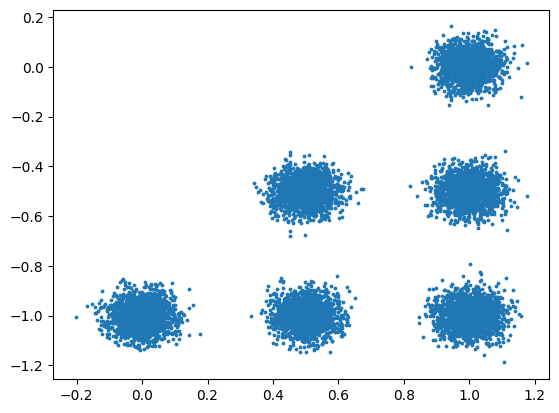

In [9]:
means = []
for i in range(5):
    for j in range(5):
        if i <= j + 1:  # Ensuring i is strictly greater than j + 1 (under the diagonal offset by 1)
            continue
        means.append([(i-2) * 5., (j-2) * 5.])

means = torch.tensor(means).to(device)
means = means / 10

# Categorical distribution with number of components equal to the number of means
mix = torch.distributions.Categorical(torch.ones(len(means),).to(device))

# Create the component distributions for the GMM
comp = torch.distributions.Independent(torch.distributions.Normal(loc=means,
                                                                  scale=gmm_var**0.5,
                                                                  validate_args=False), 1)

# Create the GMM
gmm = torch.distributions.MixtureSameFamily(mix, comp, validate_args=False)

# Sample from the GMM
samples = gmm.sample((10000,))
x0_samples = samples
normalized_samples = samples

# Plot the samples
plt.scatter(samples.detach().cpu()[:, 0], samples.detach().cpu()[:, 1], s=3)


In [10]:
dataloader = DataLoader(TensorDataset(normalized_samples), batch_size=1024, shuffle=True)

In [11]:
def score_loss(vectorfield, x, t, noise_schedule):
    h_t = noise_schedule.h(t.unsqueeze(1))
    xt = torch.normal(x, h_t ** 0.5)

    s_pred = vectorfield(t, xt)
    s_true = - (xt - x)/ (h_t + 1e-3)
    
    lambda_t = 1 /(h_t + 1e-3)
    s_diff =  torch.linalg.vector_norm(s_pred - s_true, dim=-1) ** 2 #lambda_t *
    return s_diff.mean()    

In [12]:
vectorfield = MyMLP().to(device)
optimizer = Adam(vectorfield.parameters(), lr=1e-3)
weighted = False

In [13]:
# train a score network


if os.path.exists('score_net_gmm.pt'):
    vectorfield.load_state_dict(torch.load('score_net_gmm.pt',  weights_only=True))
    vectorfield.eval()

else:
    for epoch in range(5000):
        for x0 in dataloader:
            x0 = x0[0]
            x0.requires_grad = True
            optimizer.zero_grad()

            t = torch.rand(len(x0), device=device)

            loss = score_loss(vectorfield, x0, t, noise_schedule)
            loss.backward()
            optimizer.step()

        if epoch % 300 == 0:
            print("Loss", loss.item())

            # integrate the SDE
            ve_reverse_sde = VEReverseSDE(vectorfield, noise_schedule)
            samples = generate_samples(ve_reverse_sde, 3000).detach().cpu()

            plt.scatter(samples[:, 0], samples[:, 1], s=3)
            plt.show()

    torch.save(vectorfield.state_dict(), 'score_net_gmm.pt')

### Energy Estimator


In [37]:
# sample from a tensor
def sample_from_tensor(tensor, num_samples):
    idx = torch.randint(0, tensor.shape[0], (num_samples,))
    return tensor[idx]


def estimate_grad_Rt_high_t(xt,
                            t,
                            energy, 
                            diffusion_samples,
                            noise_schedule,
                            num_mc_samples=100):

    repeated_xt = xt.unsqueeze(0)
    h_t  = noise_schedule.h(t)

    q_diffusion_proposal = sample_from_tensor(diffusion_samples, num_mc_samples)
    q_samples = q_diffusion_proposal

    
    with torch.no_grad():         
        log_p_xt = - (torch.linalg.vector_norm((q_samples.to(device) - repeated_xt.repeat(num_mc_samples, 1)), dim=-1) ** 2 
                / (2 * h_t.squeeze()))          
        log_weights = log_p_xt
        denoising_score = - ((repeated_xt.repeat(num_mc_samples, 1) - q_samples) 
                         / h_t.squeeze())
        scores = denoising_score 

    estimate = torch.sum(torch.nn.functional.softmax(log_weights, dim=0)[:, None] * scores, dim=0)
    return estimate


def estimate_grad_Rt_low_t(xt,
                           t,
                           energy,
                           diffusion_samples,
                           noise_schedule,
                           num_mc_samples=100):
    repeated_xt = xt.unsqueeze(0)
    h_t  = noise_schedule.h(t)
    device = xt.device
    
    q_normal_proposal = repeated_xt + torch.randn((num_mc_samples,) + xt.size()).to(device) * (h_t ** 0.5)
    q_samples = q_normal_proposal
    
    with torch.no_grad():
        log_p_pre = energy.log_prob(q_samples)
        log_weights = log_p_pre
        target_score  = torch.vmap(torch.func.grad(lambda x: energy.log_prob(x)))(q_samples)
        scores = target_score

    estimate = torch.sum(torch.nn.functional.softmax(log_weights, dim=0)[:, None] * scores, dim=0)
    return estimate

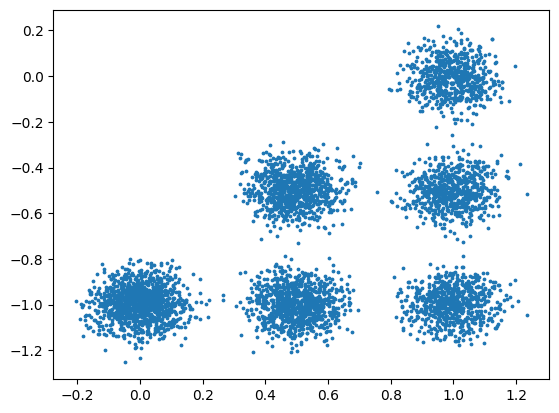

In [29]:
ve_reverse_sde = VEReverseSDE(vectorfield, noise_schedule)
diffusion_samples = generate_samples(ve_reverse_sde, 5000).detach()
plt.scatter(diffusion_samples.cpu()[:, 0], diffusion_samples.cpu()[:, 1], s=3)
plt.show()

In [17]:
from src.models.components.clipper import Clipper
clipper = Clipper(
    should_clip_scores=False, should_clip_log_rewards=False, max_score_norm=50
)

In [39]:
def reward_matching_loss(estimator,
                         model,
                         energy,
                         x,
                         t,
                         diffusion_samples,
                         noise_schedule,
                         num_mc_samples=100,
                         clip=True
    ):


    x.requires_grad = True

    h_t = noise_schedule.h(t.unsqueeze(1))
    
    # noisy sample: x(t)
    xt = torch.normal(x, h_t**0.5)

    # predicted score
    pred_scores = model(t, xt)

    estimated_scores = torch.vmap(estimator, randomness="different",
                                  in_dims=(0, 0, None, None, None))(
                                    xt,
                                    t,
                                    energy,
                                    diffusion_samples,
                                    noise_schedule,
                                    num_mc_samples=num_mc_samples,
                                ).detach()


    if clip:
        estimated_scores = clipper.clip_scores(estimated_scores)

    err = (
        estimated_scores - pred_scores
    ) ** 2
    return err.mean()

In [41]:
from src.models.components.prioritised_replay_buffer import SimpleBuffer
buffer = SimpleBuffer(
    2,
    10000,
    1000,
    initial_sampler=None,
    device=device,
    fill_buffer_during_init=False,
    sample_with_replacement=True,
    prioritize=False,
)

Buffer not initialised, expected that checkpoint will be loaded.


In [48]:
t_switch_estimators = 0.7
outer_epochs= 100
inner_epochs = 100

batch_size = 512

diffusion_samples_energy = full_gmm.log_prob(diffusion_samples.detach())
buffer.add(diffusion_samples, diffusion_samples_energy)

train_dataset = TensorDataset(diffusion_samples.detach(), diffusion_samples_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

num_mc_samples = 200

In [49]:
#copy vectorfield parameters
model = copy.deepcopy(vectorfield)
optimizer = Adam(model.parameters(), lr=1e-3)
weighted = False

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Loss 60.785698
Epoch 49 | Loss 8.757269
Epoch 98 | Loss 7.312378


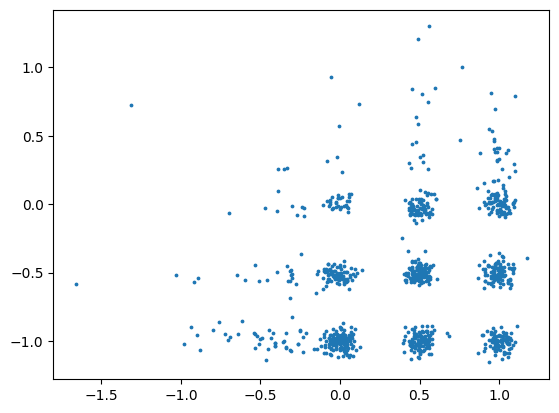

  1%|          | 1/100 [00:09<16:00,  9.70s/it]

Epoch 0 | Loss 17.849068
Epoch 49 | Loss 7.273940
Epoch 98 | Loss 5.721033


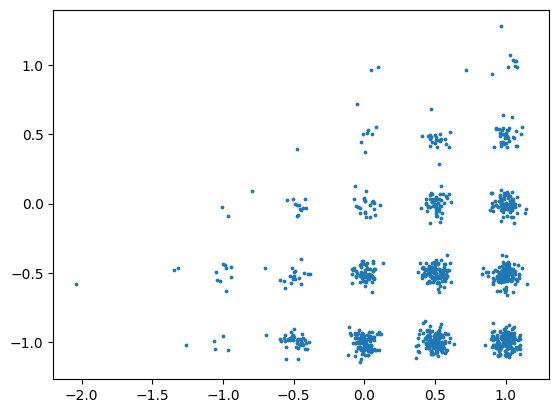

  2%|▏         | 2/100 [00:19<15:48,  9.67s/it]

Epoch 0 | Loss 7.068878
Epoch 49 | Loss 8.281193
Epoch 98 | Loss 7.539590


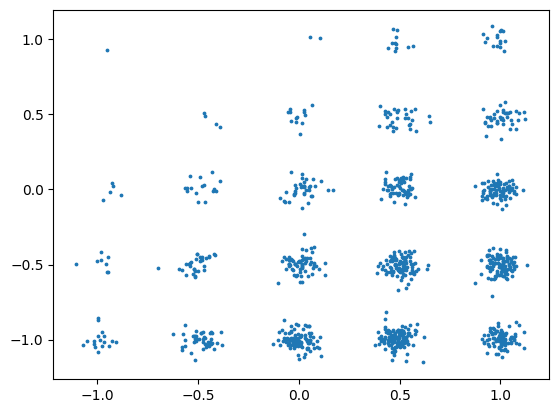

  3%|▎         | 3/100 [00:29<15:39,  9.68s/it]

Epoch 0 | Loss 8.324548
Epoch 49 | Loss 10.331197
Epoch 98 | Loss 6.387301


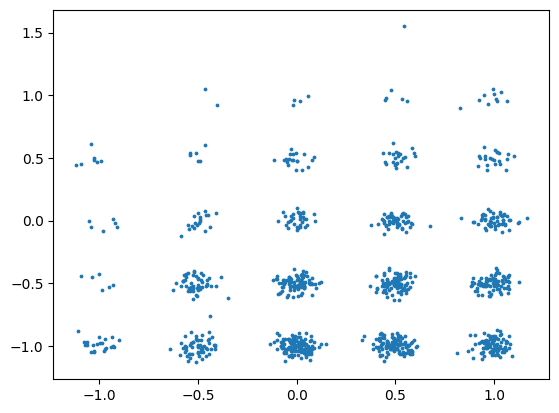

  4%|▍         | 4/100 [00:38<15:34,  9.74s/it]

Epoch 0 | Loss 10.932489
Epoch 49 | Loss 7.218267
Epoch 98 | Loss 8.003353


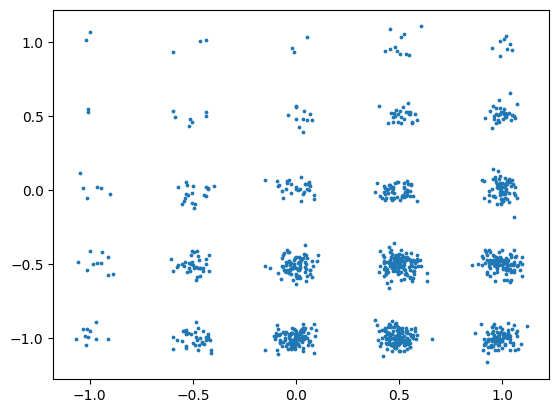

  5%|▌         | 5/100 [00:48<15:21,  9.70s/it]

Epoch 0 | Loss 9.087798
Epoch 49 | Loss 5.421245
Epoch 98 | Loss 7.289084


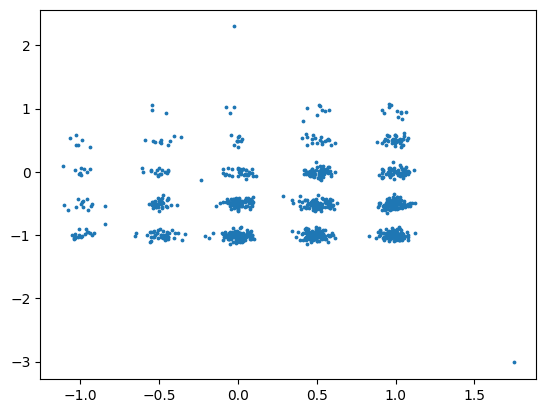

  6%|▌         | 6/100 [00:58<15:10,  9.69s/it]

Epoch 0 | Loss 6.737860
Epoch 49 | Loss 4.653443
Epoch 98 | Loss 8.168430


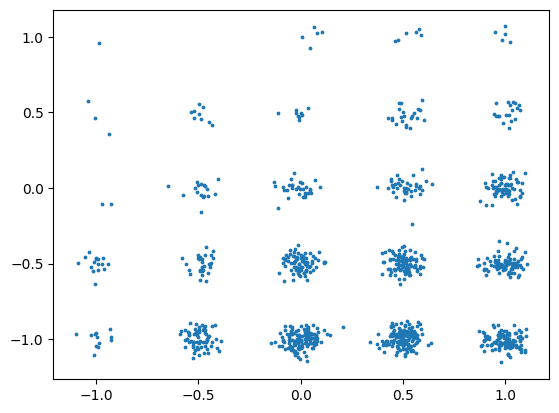

  7%|▋         | 7/100 [01:07<14:59,  9.67s/it]

Epoch 0 | Loss 7.702503
Epoch 49 | Loss 6.168872
Epoch 98 | Loss 5.830671


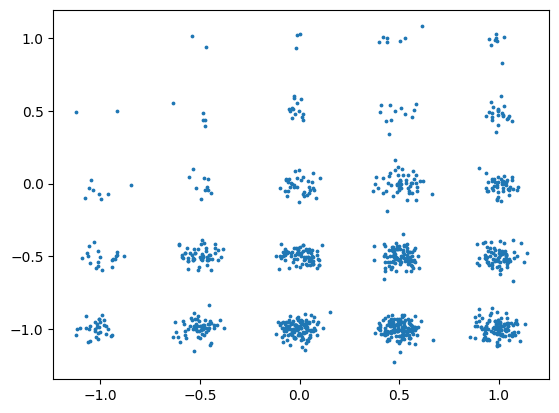

  8%|▊         | 8/100 [01:17<14:52,  9.70s/it]

Epoch 0 | Loss 5.810736
Epoch 49 | Loss 7.554522
Epoch 98 | Loss 7.809826


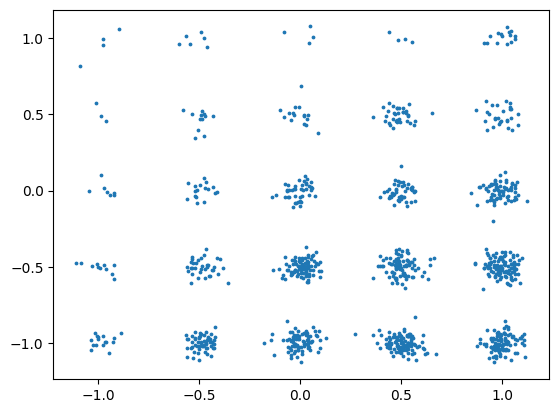

  9%|▉         | 9/100 [01:27<14:40,  9.68s/it]

Epoch 0 | Loss 12.687453
Epoch 49 | Loss 6.770530
Epoch 98 | Loss 6.240276


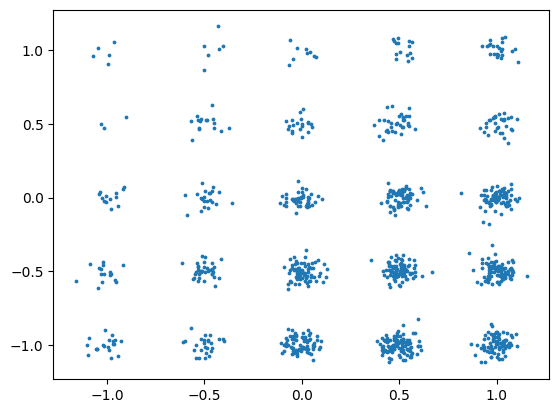

 10%|█         | 10/100 [01:36<14:32,  9.69s/it]

Epoch 0 | Loss 6.137654
Epoch 49 | Loss 5.661831
Epoch 98 | Loss 7.262207


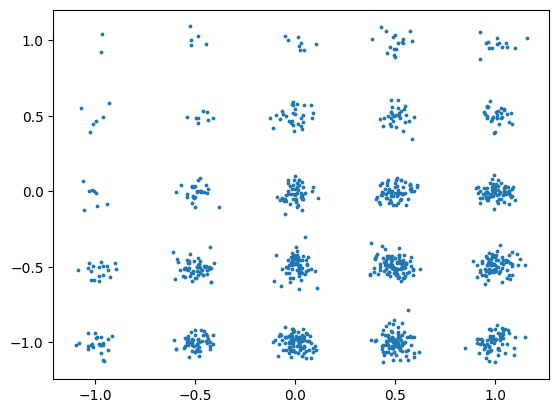

 11%|█         | 11/100 [01:46<14:25,  9.72s/it]

Epoch 0 | Loss 6.916010
Epoch 49 | Loss 7.942095
Epoch 98 | Loss 7.123606


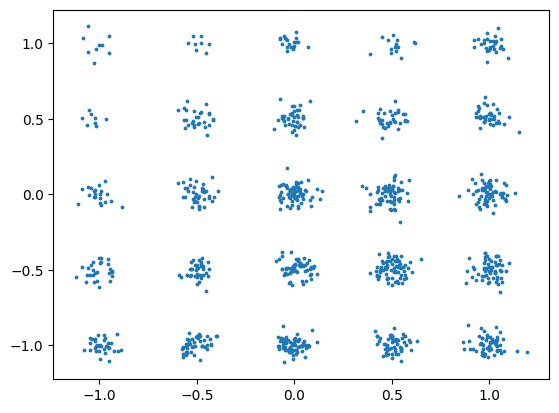

 12%|█▏        | 12/100 [01:56<14:12,  9.69s/it]

Epoch 0 | Loss 6.699018
Epoch 49 | Loss 5.920305
Epoch 98 | Loss 5.493363


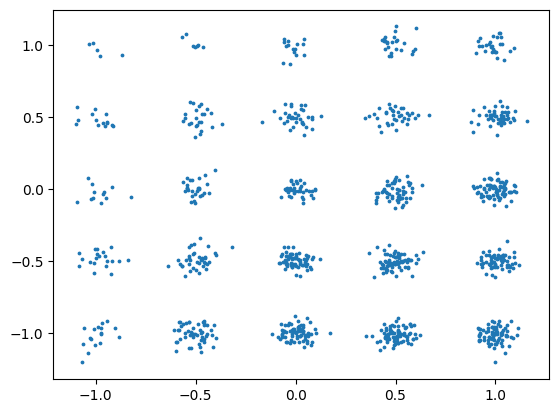

 13%|█▎        | 13/100 [02:05<14:01,  9.68s/it]

Epoch 0 | Loss 4.498557
Epoch 49 | Loss 7.879199
Epoch 98 | Loss 7.295855


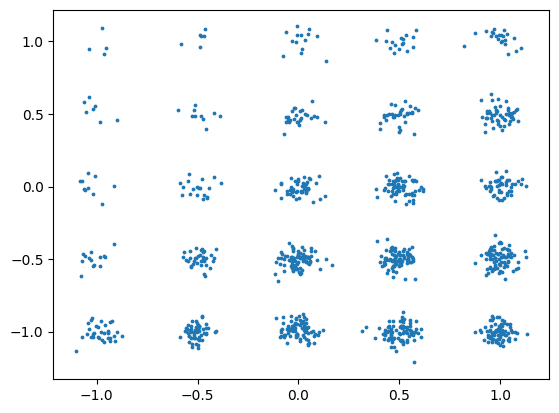

 14%|█▍        | 14/100 [02:15<13:50,  9.66s/it]

Epoch 0 | Loss 5.823814
Epoch 49 | Loss 5.527722
Epoch 98 | Loss 11.859623


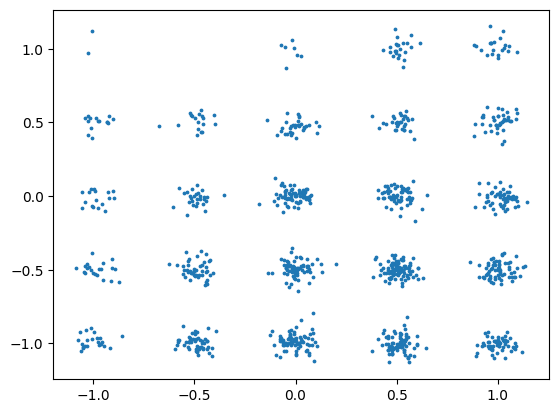

 15%|█▌        | 15/100 [02:25<13:43,  9.69s/it]

Epoch 0 | Loss 7.188288
Epoch 49 | Loss 4.235779
Epoch 98 | Loss 5.024850


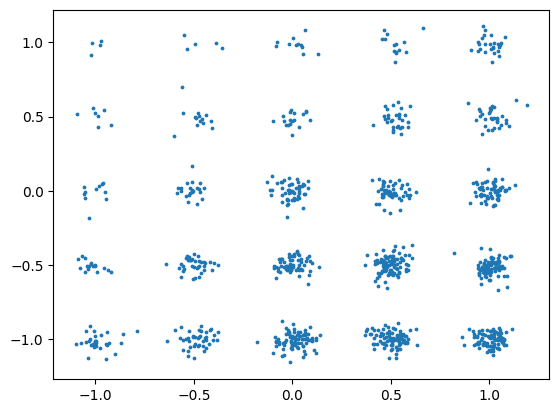

 16%|█▌        | 16/100 [02:35<13:33,  9.69s/it]

Epoch 0 | Loss 7.677050
Epoch 49 | Loss 6.979207
Epoch 98 | Loss 10.024015


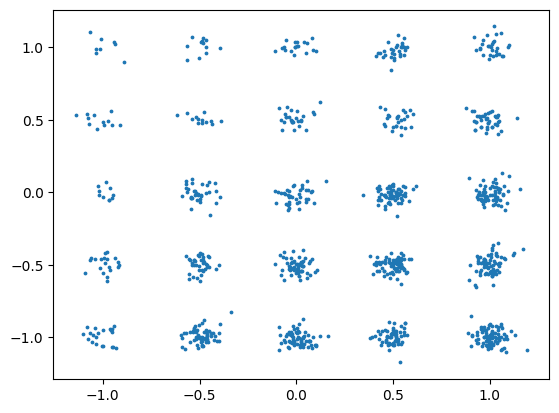

 17%|█▋        | 17/100 [02:44<13:24,  9.69s/it]

Epoch 0 | Loss 7.635891
Epoch 49 | Loss 6.769864
Epoch 98 | Loss 8.346815


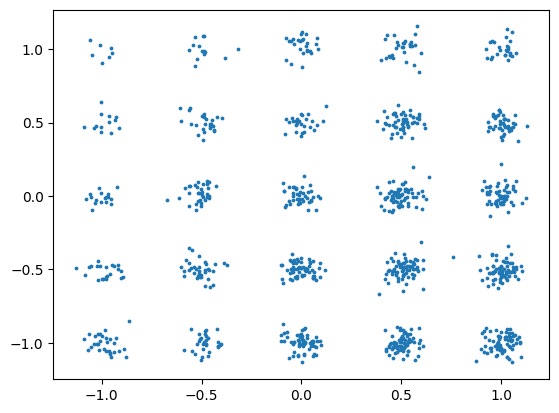

 18%|█▊        | 18/100 [02:54<13:15,  9.71s/it]

Epoch 0 | Loss 5.875923
Epoch 49 | Loss 4.777035
Epoch 98 | Loss 5.156554


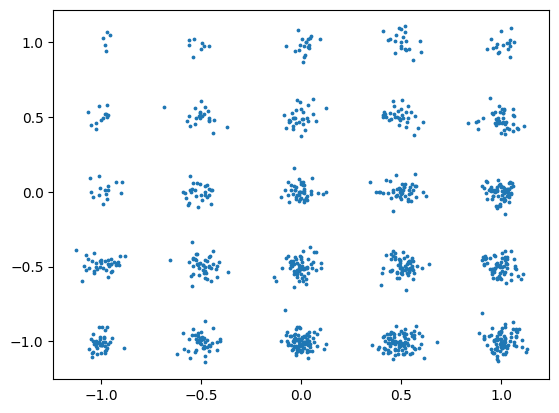

 19%|█▉        | 19/100 [03:04<13:05,  9.69s/it]

Epoch 0 | Loss 4.262135
Epoch 49 | Loss 5.112926
Epoch 98 | Loss 5.846988


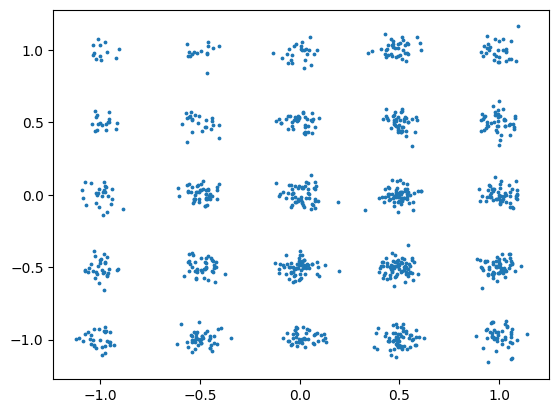

 20%|██        | 20/100 [03:13<12:54,  9.69s/it]

Epoch 0 | Loss 6.096645
Epoch 49 | Loss 5.367023
Epoch 98 | Loss 4.074586


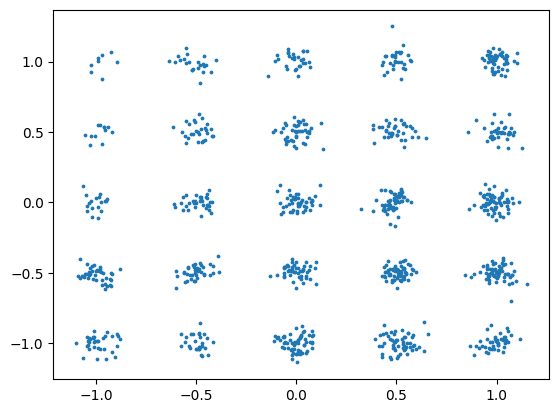

 21%|██        | 21/100 [03:23<12:43,  9.67s/it]

Epoch 0 | Loss 6.841474
Epoch 49 | Loss 6.507132
Epoch 98 | Loss 6.185258


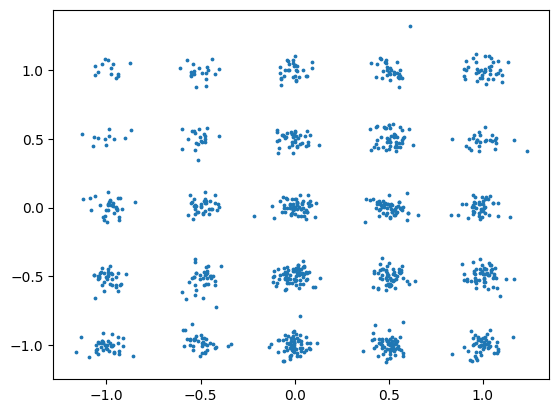

 22%|██▏       | 22/100 [03:33<12:35,  9.69s/it]

Epoch 0 | Loss 8.204603
Epoch 49 | Loss 6.086939
Epoch 98 | Loss 8.827619


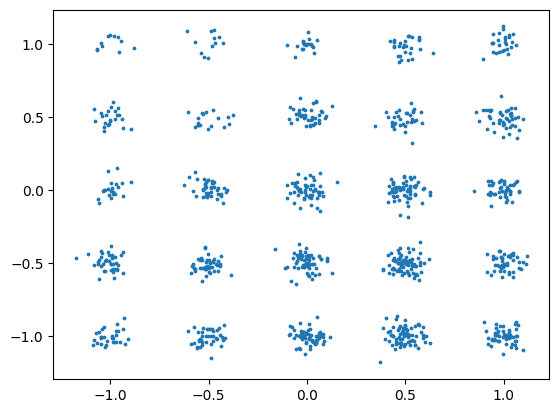

 23%|██▎       | 23/100 [03:42<12:25,  9.68s/it]

Epoch 0 | Loss 6.739122
Epoch 49 | Loss 8.062727
Epoch 98 | Loss 8.653090


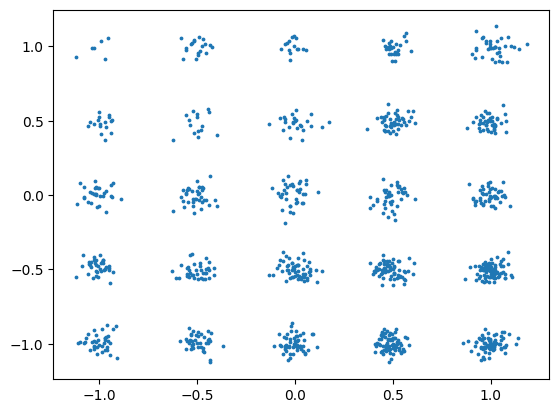

 24%|██▍       | 24/100 [03:52<12:15,  9.67s/it]

Epoch 0 | Loss 5.646919
Epoch 49 | Loss 5.704971
Epoch 98 | Loss 5.716897


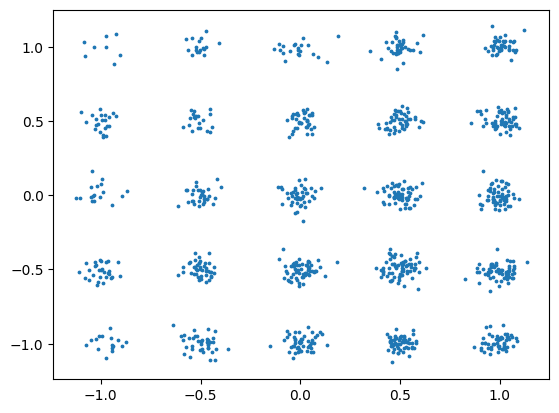

 25%|██▌       | 25/100 [04:02<12:07,  9.70s/it]

Epoch 0 | Loss 5.685627
Epoch 49 | Loss 5.155952
Epoch 98 | Loss 6.646398


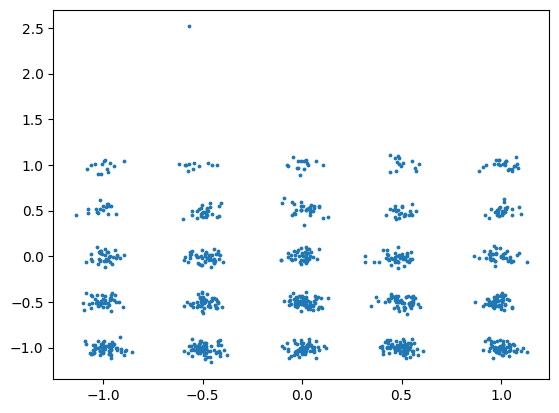

 26%|██▌       | 26/100 [04:11<11:58,  9.71s/it]

Epoch 0 | Loss 8.681762
Epoch 49 | Loss 5.925943
Epoch 98 | Loss 7.356271


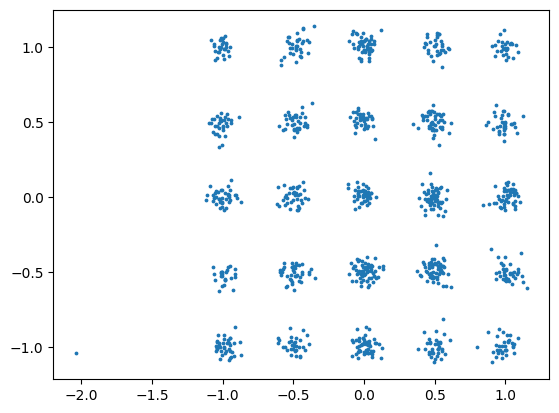

 27%|██▋       | 27/100 [04:21<11:49,  9.72s/it]

Epoch 0 | Loss 8.390107
Epoch 49 | Loss 9.314073
Epoch 98 | Loss 5.203406


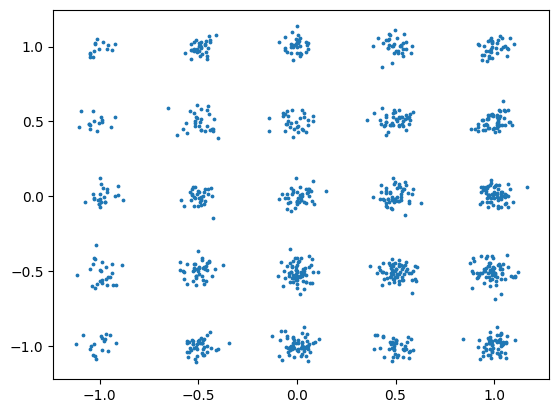

 28%|██▊       | 28/100 [04:31<11:40,  9.73s/it]

Epoch 0 | Loss 6.230399
Epoch 49 | Loss 4.725696
Epoch 98 | Loss 4.269267


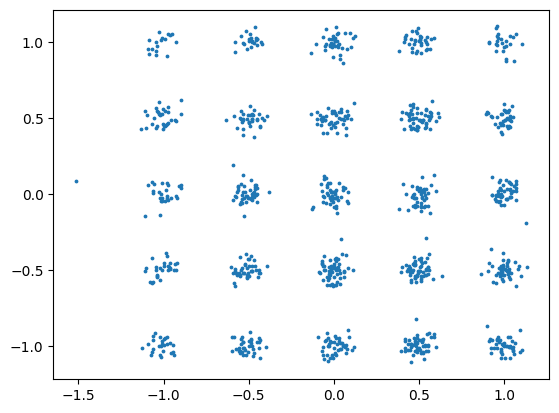

 29%|██▉       | 29/100 [04:41<11:29,  9.71s/it]

Epoch 0 | Loss 6.459935
Epoch 49 | Loss 6.043459
Epoch 98 | Loss 5.795247


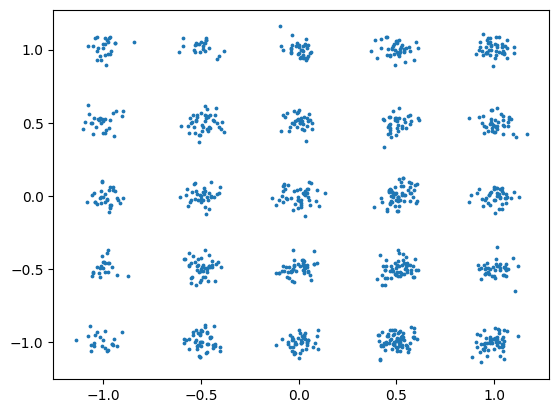

 30%|███       | 30/100 [04:50<11:18,  9.69s/it]

Epoch 0 | Loss 4.992527
Epoch 49 | Loss 5.417078
Epoch 98 | Loss 4.877261


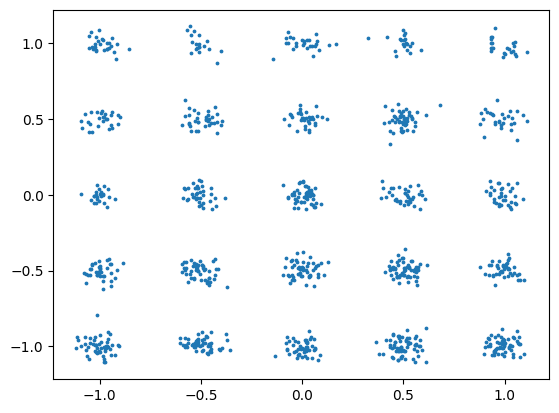

 31%|███       | 31/100 [05:00<11:09,  9.71s/it]

Epoch 0 | Loss 5.573617
Epoch 49 | Loss 7.761240
Epoch 98 | Loss 6.664247


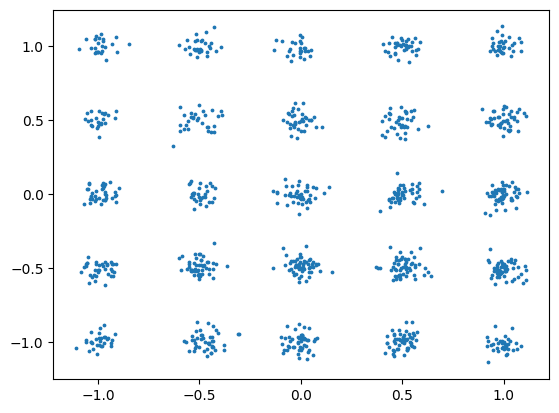

 32%|███▏      | 32/100 [05:10<10:59,  9.69s/it]

Epoch 0 | Loss 7.167632
Epoch 49 | Loss 5.417027
Epoch 98 | Loss 7.917492


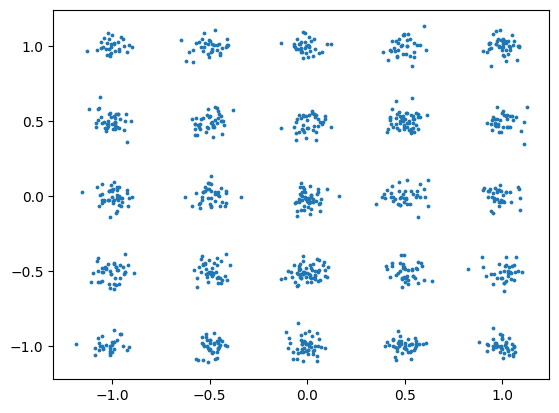

 33%|███▎      | 33/100 [05:19<10:48,  9.68s/it]

Epoch 0 | Loss 5.796283
Epoch 49 | Loss 8.624435
Epoch 98 | Loss 5.026602


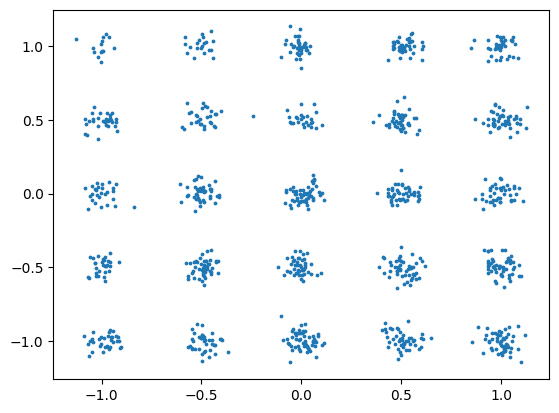

 34%|███▍      | 34/100 [05:29<10:38,  9.67s/it]

Epoch 0 | Loss 8.496144
Epoch 49 | Loss 5.159520
Epoch 98 | Loss 6.024266


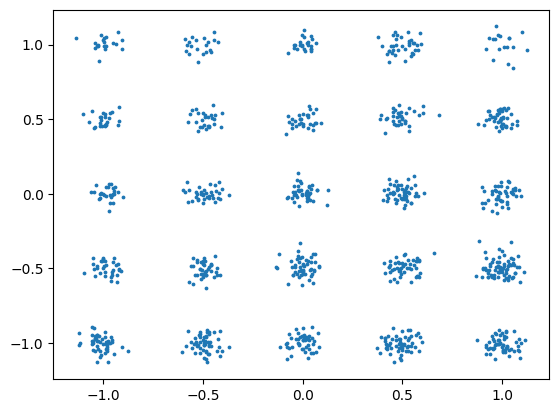

 35%|███▌      | 35/100 [05:39<10:29,  9.69s/it]

Epoch 0 | Loss 7.090569
Epoch 49 | Loss 7.073204
Epoch 98 | Loss 7.822651


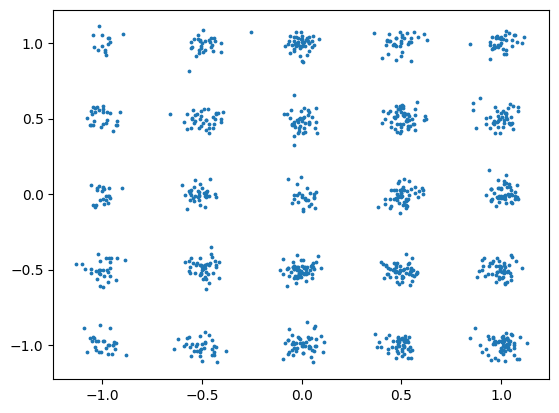

 36%|███▌      | 36/100 [05:48<10:19,  9.68s/it]

Epoch 0 | Loss 8.898625
Epoch 49 | Loss 5.795274
Epoch 98 | Loss 4.789924


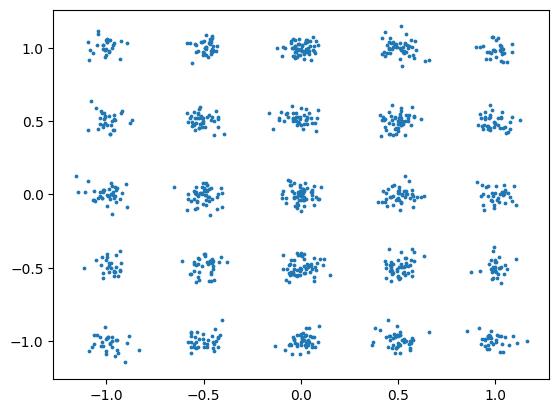

 37%|███▋      | 37/100 [05:58<10:11,  9.70s/it]

Epoch 0 | Loss 7.426925
Epoch 49 | Loss 8.890644
Epoch 98 | Loss 5.652389


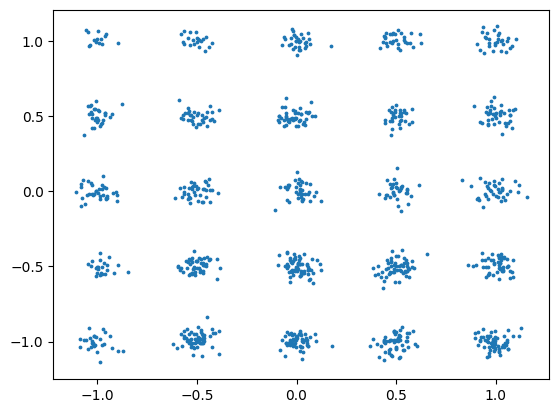

 38%|███▊      | 38/100 [06:08<10:00,  9.69s/it]

Epoch 0 | Loss 5.441967
Epoch 49 | Loss 6.564440
Epoch 98 | Loss 6.694466


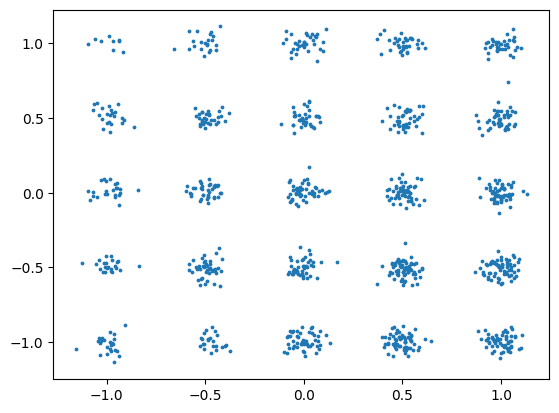

 39%|███▉      | 39/100 [06:18<09:52,  9.71s/it]

Epoch 0 | Loss 5.623977
Epoch 49 | Loss 6.548241
Epoch 98 | Loss 5.554133


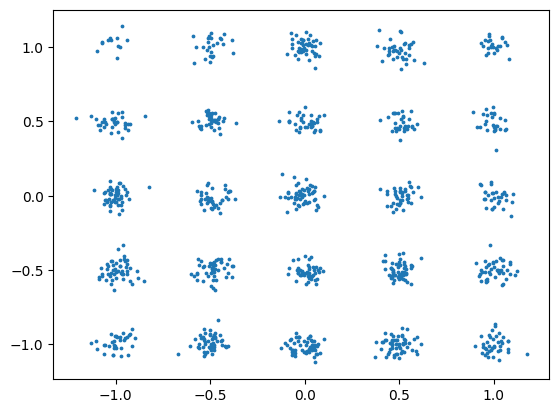

 40%|████      | 40/100 [06:27<09:45,  9.75s/it]

Epoch 0 | Loss 5.536725
Epoch 49 | Loss 4.543268
Epoch 98 | Loss 8.231620


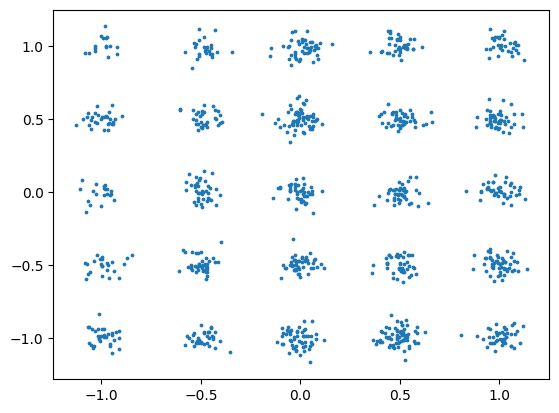

 41%|████      | 41/100 [06:37<09:35,  9.76s/it]

Epoch 0 | Loss 6.286891
Epoch 49 | Loss 11.039525
Epoch 98 | Loss 5.814073


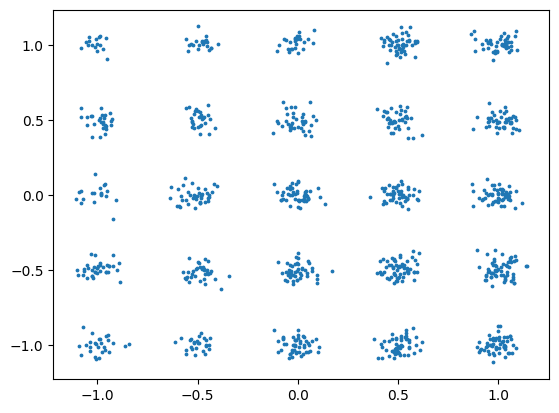

 42%|████▏     | 42/100 [06:47<09:27,  9.79s/it]

Epoch 0 | Loss 3.856117
Epoch 49 | Loss 4.772311
Epoch 98 | Loss 10.724034


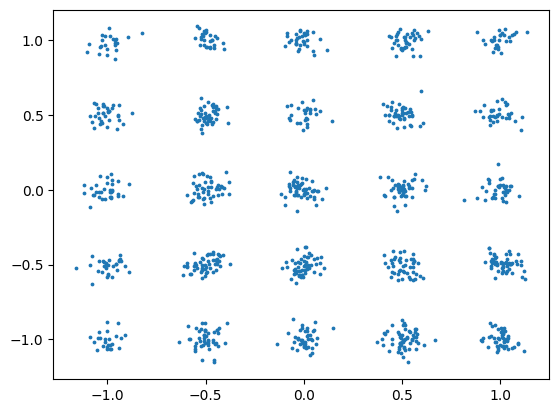

 43%|████▎     | 43/100 [06:57<09:17,  9.78s/it]

Epoch 0 | Loss 5.213815
Epoch 49 | Loss 4.294309
Epoch 98 | Loss 11.970801


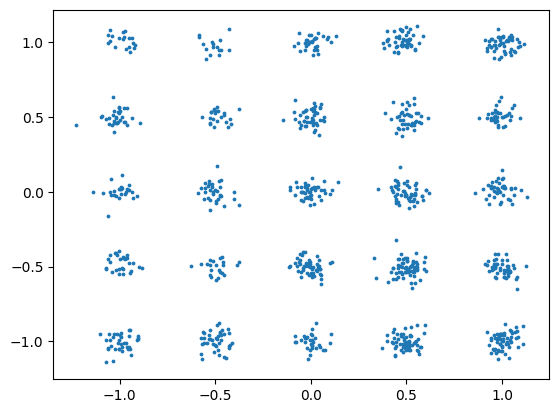

 44%|████▍     | 44/100 [07:07<09:08,  9.80s/it]

Epoch 0 | Loss 4.108536
Epoch 49 | Loss 8.322863
Epoch 98 | Loss 5.687410


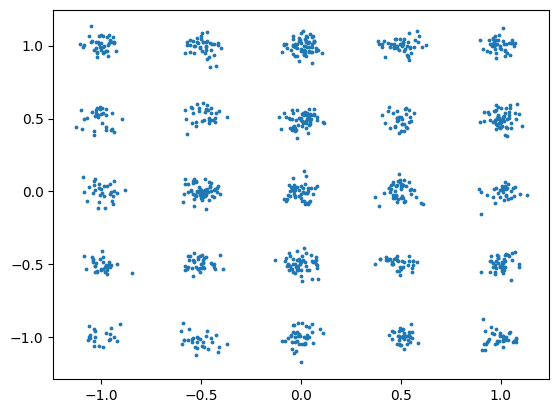

 45%|████▌     | 45/100 [07:16<08:56,  9.75s/it]

Epoch 0 | Loss 9.229083
Epoch 49 | Loss 4.703773
Epoch 98 | Loss 6.415644


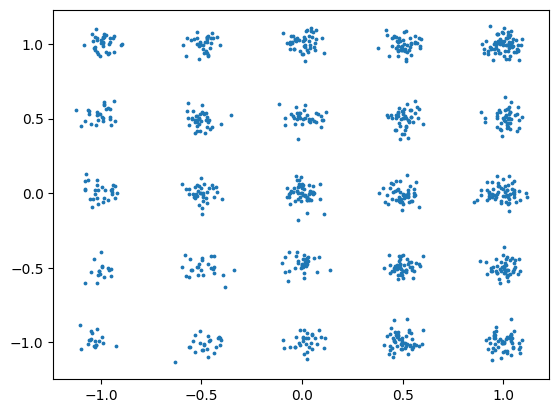

 46%|████▌     | 46/100 [07:26<08:45,  9.73s/it]

Epoch 0 | Loss 5.716600
Epoch 49 | Loss 6.779215
Epoch 98 | Loss 9.131829


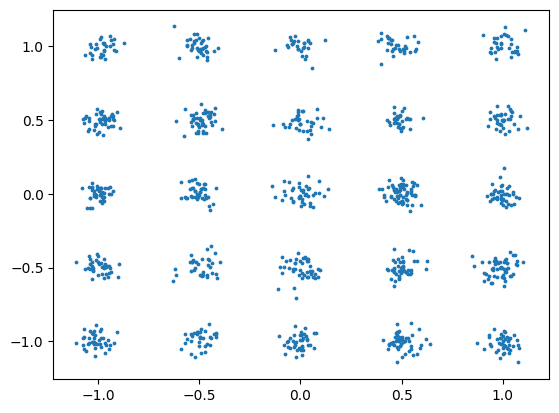

 47%|████▋     | 47/100 [07:36<08:35,  9.73s/it]

Epoch 0 | Loss 5.960314
Epoch 49 | Loss 4.964182
Epoch 98 | Loss 5.397497


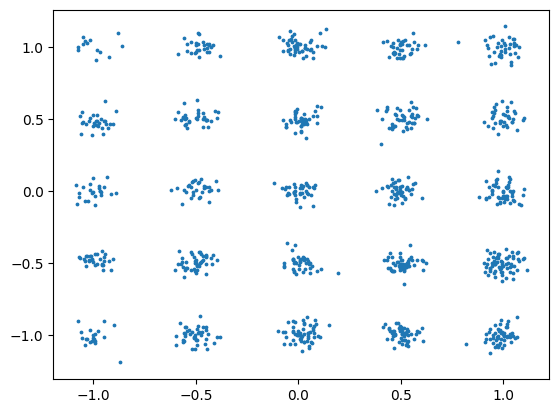

 48%|████▊     | 48/100 [07:45<08:27,  9.76s/it]

Epoch 0 | Loss 6.680744
Epoch 49 | Loss 4.964102
Epoch 98 | Loss 5.185767


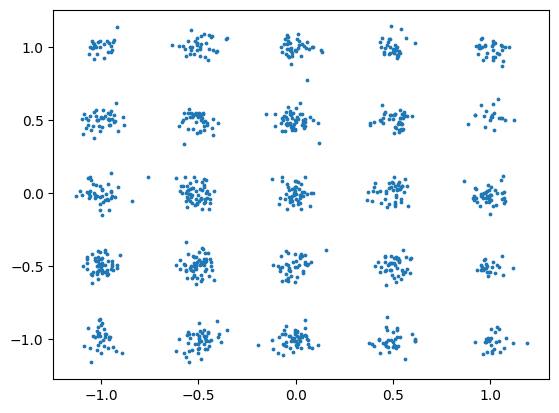

 49%|████▉     | 49/100 [07:55<08:17,  9.76s/it]

Epoch 0 | Loss 4.978978
Epoch 49 | Loss 9.751156
Epoch 98 | Loss 4.492841


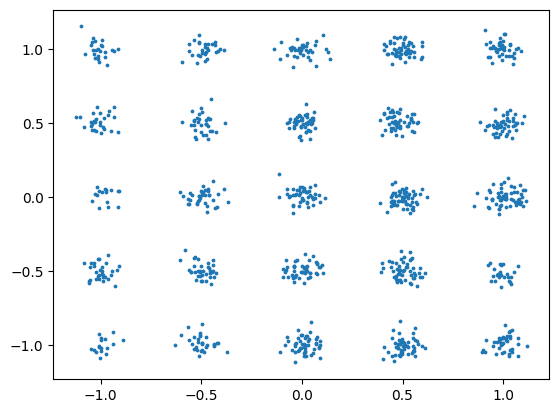

 50%|█████     | 50/100 [08:05<08:08,  9.78s/it]

Epoch 0 | Loss 4.560932
Epoch 49 | Loss 6.579498
Epoch 98 | Loss 12.969829


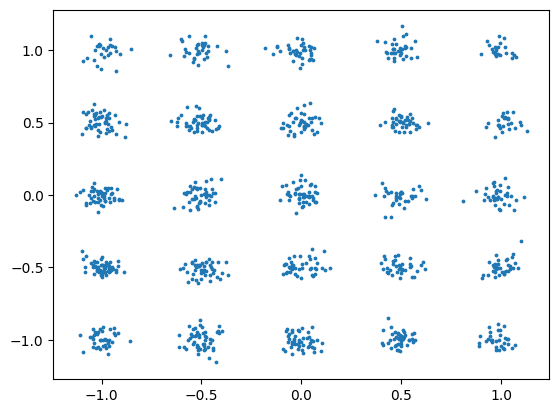

 51%|█████     | 51/100 [08:15<07:58,  9.77s/it]

Epoch 0 | Loss 5.878586
Epoch 49 | Loss 5.492544
Epoch 98 | Loss 5.122630


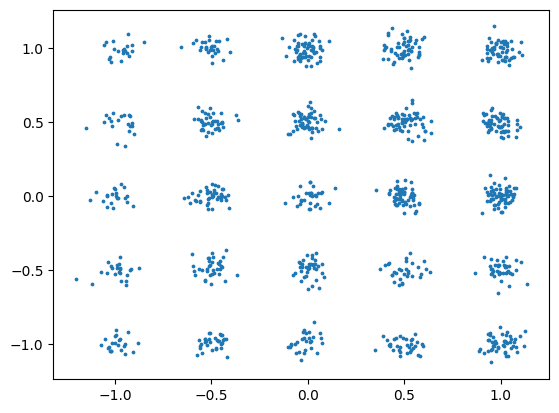

 52%|█████▏    | 52/100 [08:25<07:58,  9.97s/it]

Epoch 0 | Loss 5.392833
Epoch 49 | Loss 8.874445
Epoch 98 | Loss 5.978749


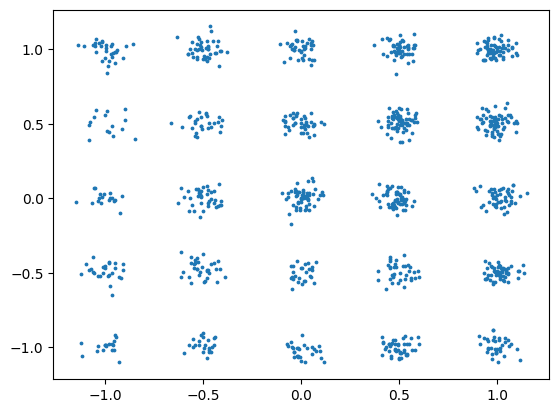

 53%|█████▎    | 53/100 [08:35<07:46,  9.93s/it]

Epoch 0 | Loss 7.603432
Epoch 49 | Loss 7.176849
Epoch 98 | Loss 5.819376


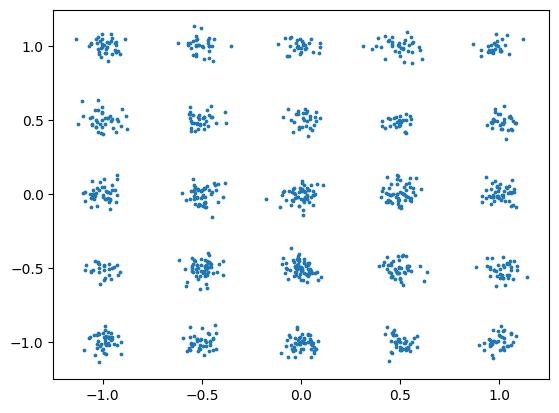

 54%|█████▍    | 54/100 [08:45<07:36,  9.93s/it]

Epoch 0 | Loss 4.462914
Epoch 49 | Loss 7.588818
Epoch 98 | Loss 13.156672


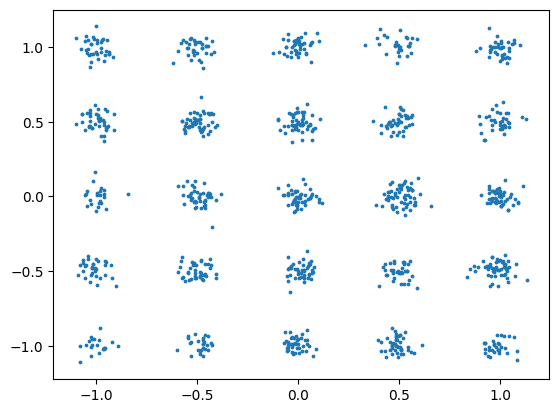

 55%|█████▌    | 55/100 [08:55<07:24,  9.88s/it]

Epoch 0 | Loss 5.652155
Epoch 49 | Loss 7.077093
Epoch 98 | Loss 7.617568


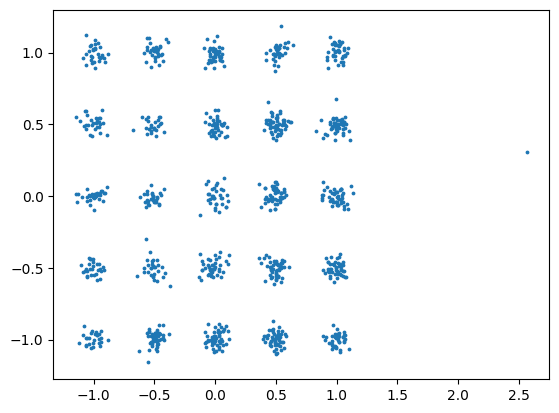

 56%|█████▌    | 56/100 [09:05<07:15,  9.89s/it]

Epoch 0 | Loss 4.537614
Epoch 49 | Loss 6.108481
Epoch 98 | Loss 5.958402


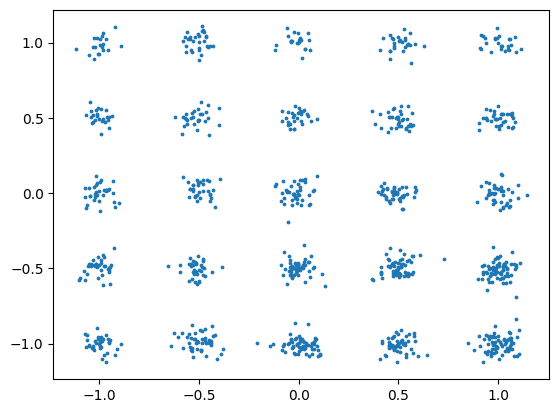

 57%|█████▋    | 57/100 [09:14<07:02,  9.83s/it]

Epoch 0 | Loss 5.011788
Epoch 49 | Loss 5.936944
Epoch 98 | Loss 7.046141


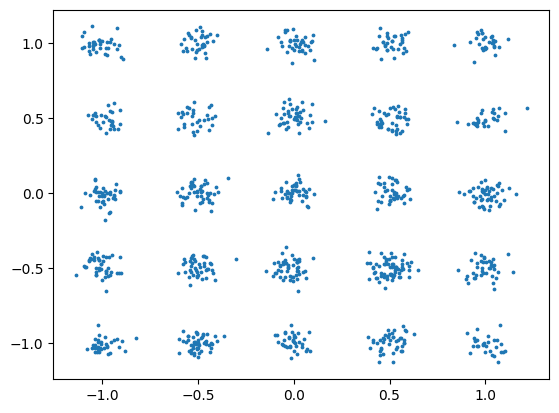

 58%|█████▊    | 58/100 [09:24<06:51,  9.80s/it]

Epoch 0 | Loss 5.777684
Epoch 49 | Loss 6.607532
Epoch 98 | Loss 5.465488


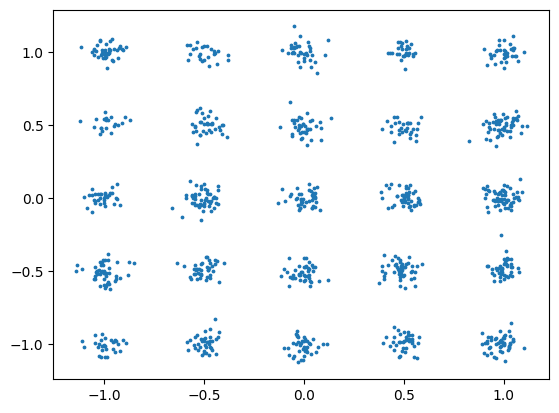

 59%|█████▉    | 59/100 [09:34<06:40,  9.76s/it]

Epoch 0 | Loss 4.925651
Epoch 49 | Loss 5.150901
Epoch 98 | Loss 6.801880


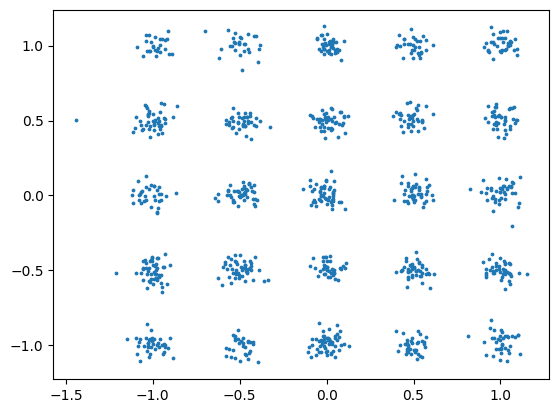

 60%|██████    | 60/100 [09:44<06:31,  9.79s/it]

Epoch 0 | Loss 12.905525
Epoch 49 | Loss 8.733543
Epoch 98 | Loss 5.620878


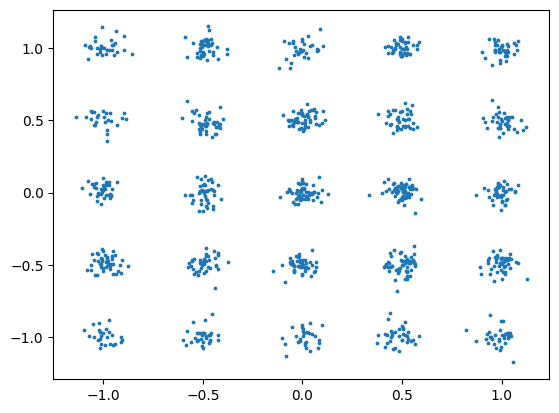

 61%|██████    | 61/100 [09:53<06:20,  9.77s/it]

Epoch 0 | Loss 5.548327
Epoch 49 | Loss 7.279334
Epoch 98 | Loss 6.285760


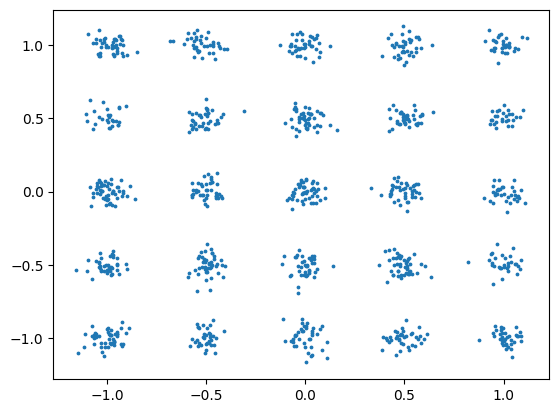

 62%|██████▏   | 62/100 [10:03<06:12,  9.80s/it]

Epoch 0 | Loss 6.135887
Epoch 49 | Loss 5.412265
Epoch 98 | Loss 5.231563


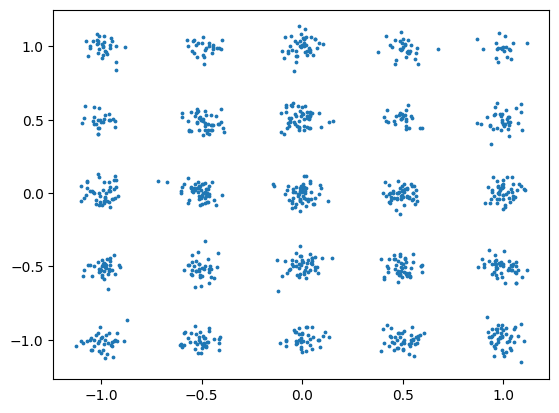

 63%|██████▎   | 63/100 [10:13<06:01,  9.78s/it]

Epoch 0 | Loss 7.934852
Epoch 49 | Loss 7.393355
Epoch 98 | Loss 7.313127


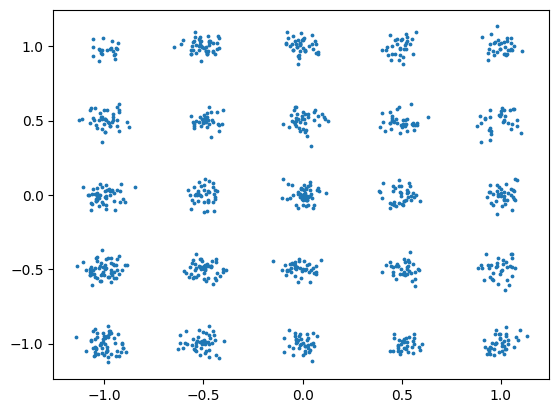

 64%|██████▍   | 64/100 [10:23<05:51,  9.77s/it]

Epoch 0 | Loss 8.819195
Epoch 49 | Loss 9.692734
Epoch 98 | Loss 8.496048


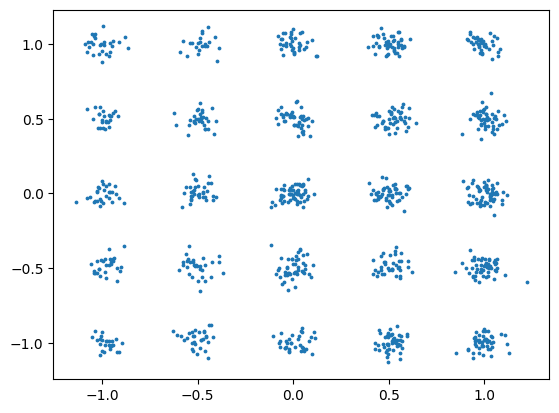

 65%|██████▌   | 65/100 [10:32<05:40,  9.74s/it]

Epoch 0 | Loss 5.650647
Epoch 49 | Loss 7.476679
Epoch 98 | Loss 4.900589


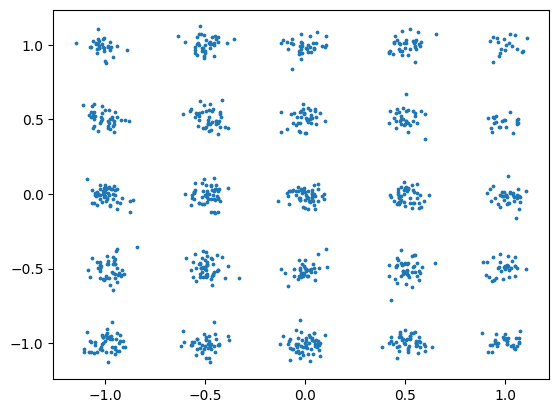

 66%|██████▌   | 66/100 [10:42<05:30,  9.73s/it]

Epoch 0 | Loss 6.215576
Epoch 49 | Loss 5.471700
Epoch 98 | Loss 8.232494


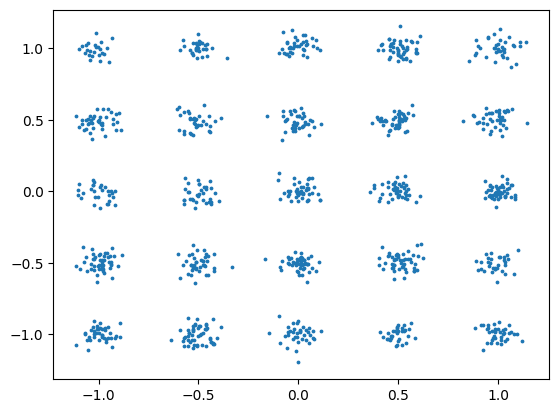

 67%|██████▋   | 67/100 [10:52<05:20,  9.70s/it]

Epoch 0 | Loss 4.914533
Epoch 49 | Loss 5.260302
Epoch 98 | Loss 6.877286


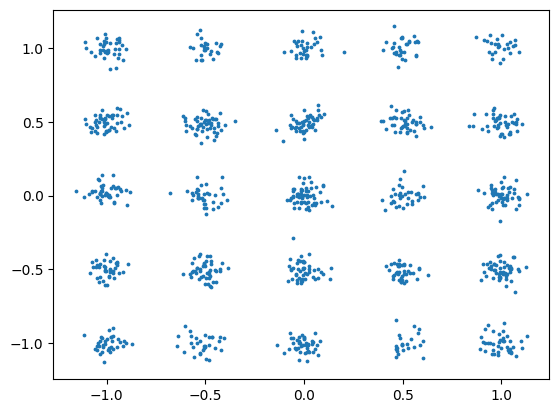

 68%|██████▊   | 68/100 [11:01<05:09,  9.68s/it]

Epoch 0 | Loss 7.572840
Epoch 49 | Loss 4.789248
Epoch 98 | Loss 4.928910


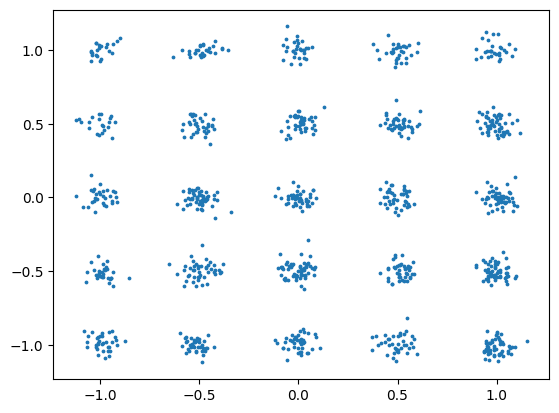

 69%|██████▉   | 69/100 [11:11<05:00,  9.69s/it]

Epoch 0 | Loss 7.440976
Epoch 49 | Loss 5.648287
Epoch 98 | Loss 6.255908


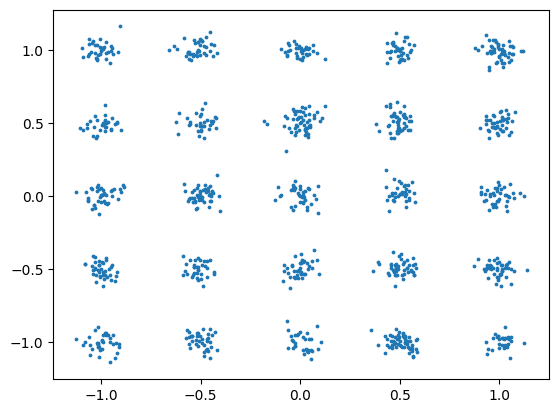

 70%|███████   | 70/100 [11:21<04:50,  9.69s/it]

Epoch 0 | Loss 6.799252
Epoch 49 | Loss 5.780820
Epoch 98 | Loss 6.497970


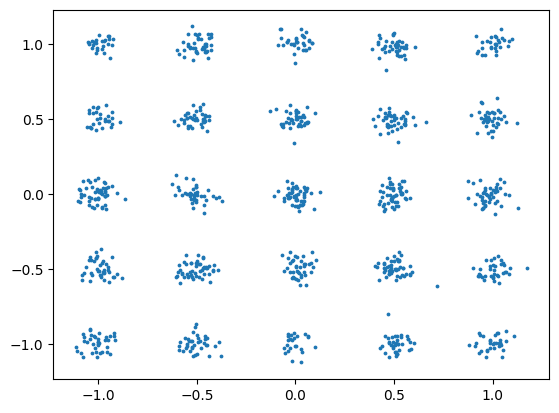

 71%|███████   | 71/100 [11:31<04:43,  9.77s/it]

Epoch 0 | Loss 8.656427
Epoch 49 | Loss 7.434724
Epoch 98 | Loss 5.928494


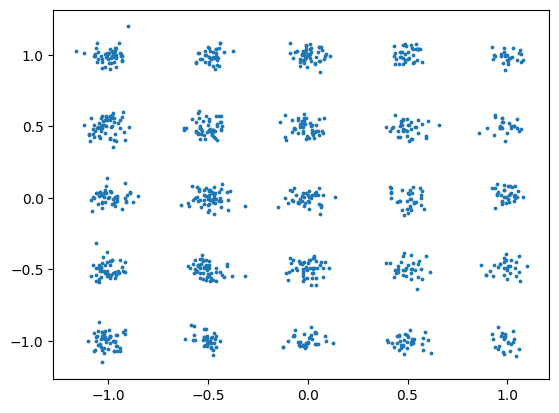

 72%|███████▏  | 72/100 [11:41<04:33,  9.78s/it]

Epoch 0 | Loss 6.253815
Epoch 49 | Loss 4.570193
Epoch 98 | Loss 4.926876


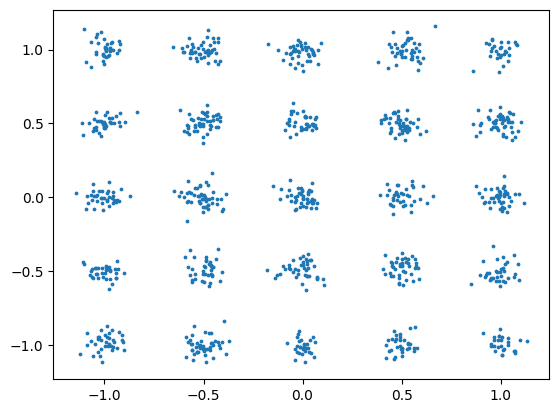

 73%|███████▎  | 73/100 [11:50<04:24,  9.80s/it]

Epoch 0 | Loss 4.268462
Epoch 49 | Loss 5.391168
Epoch 98 | Loss 6.007119


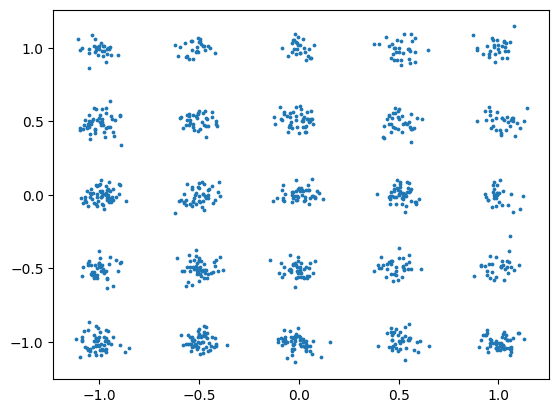

 74%|███████▍  | 74/100 [12:00<04:14,  9.78s/it]

Epoch 0 | Loss 6.581594
Epoch 49 | Loss 6.254361
Epoch 98 | Loss 9.018399


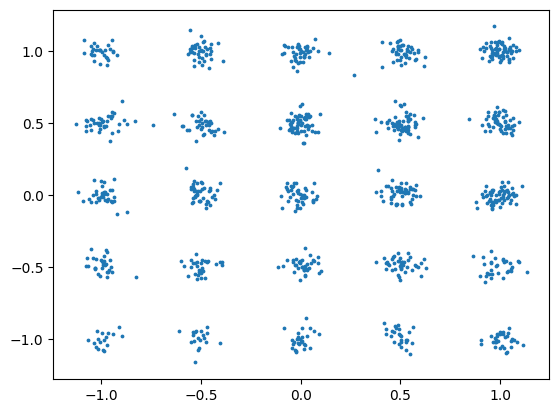

 75%|███████▌  | 75/100 [12:10<04:05,  9.80s/it]

Epoch 0 | Loss 7.307821
Epoch 49 | Loss 8.990584
Epoch 98 | Loss 3.575861


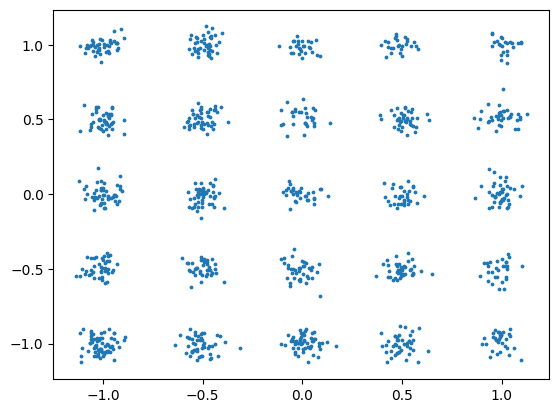

 76%|███████▌  | 76/100 [12:20<03:55,  9.79s/it]

Epoch 0 | Loss 5.498200
Epoch 49 | Loss 5.571234
Epoch 98 | Loss 7.947402


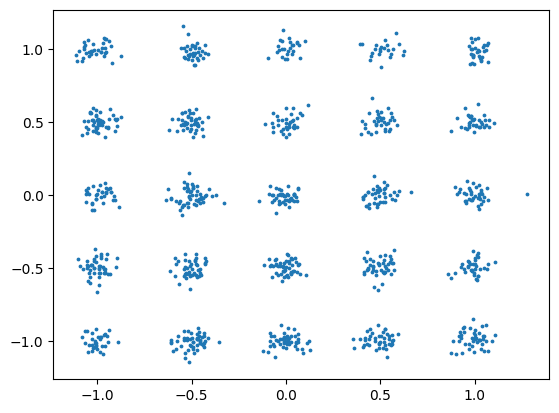

 77%|███████▋  | 77/100 [12:30<03:46,  9.84s/it]

Epoch 0 | Loss 5.734517
Epoch 49 | Loss 5.880157
Epoch 98 | Loss 8.215398


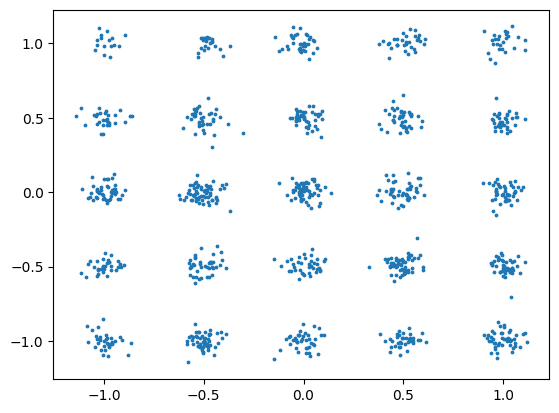

 78%|███████▊  | 78/100 [12:39<03:36,  9.83s/it]

Epoch 0 | Loss 6.267392
Epoch 49 | Loss 4.312540
Epoch 98 | Loss 10.000259


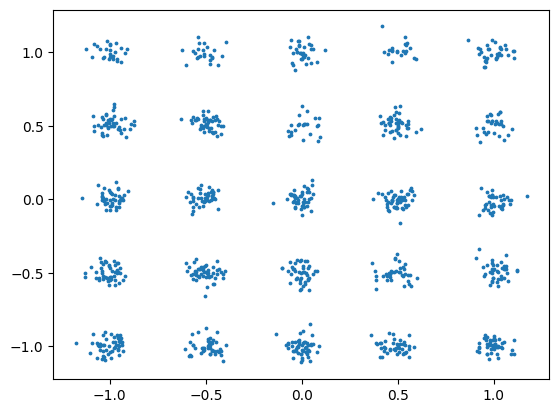

 79%|███████▉  | 79/100 [12:49<03:26,  9.84s/it]

Epoch 0 | Loss 7.089489
Epoch 49 | Loss 7.231173
Epoch 98 | Loss 8.175776


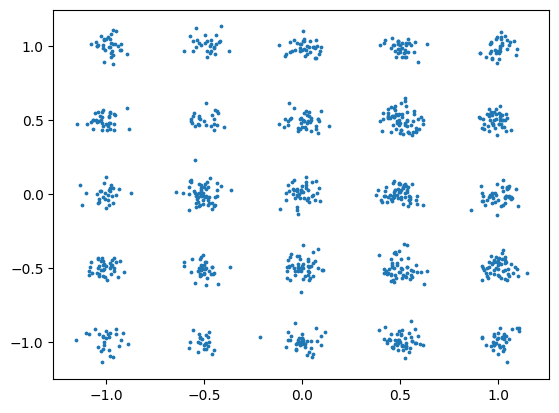

 80%|████████  | 80/100 [12:59<03:16,  9.82s/it]

Epoch 0 | Loss 6.388412
Epoch 49 | Loss 5.296579
Epoch 98 | Loss 5.444035


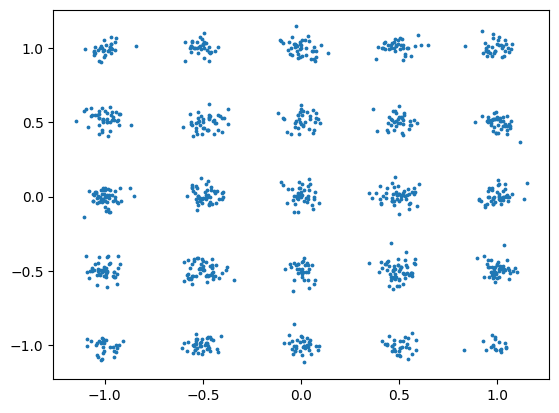

 81%|████████  | 81/100 [13:09<03:06,  9.84s/it]

Epoch 0 | Loss 4.813859
Epoch 49 | Loss 5.400743
Epoch 98 | Loss 14.002022


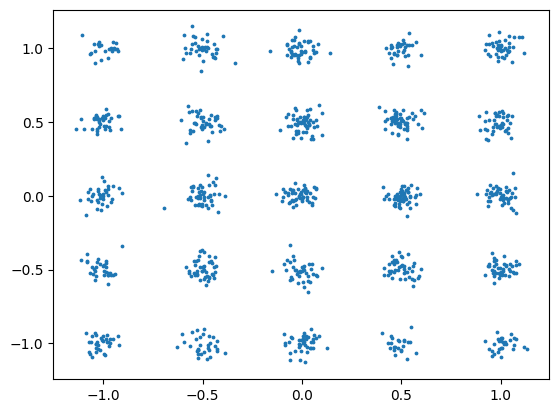

 82%|████████▏ | 82/100 [13:19<02:56,  9.82s/it]

Epoch 0 | Loss 7.964218
Epoch 49 | Loss 5.242397
Epoch 98 | Loss 7.312897


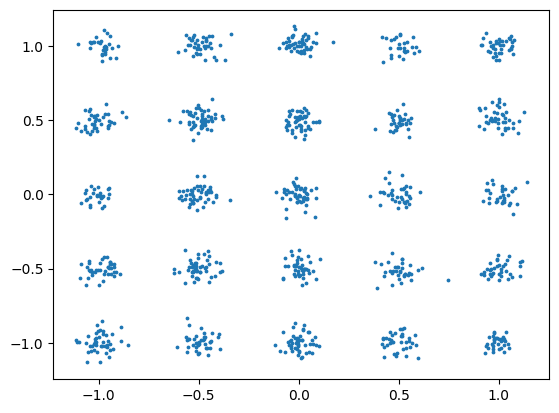

 83%|████████▎ | 83/100 [13:29<02:47,  9.85s/it]

Epoch 0 | Loss 8.321358
Epoch 49 | Loss 12.308109
Epoch 98 | Loss 7.255772


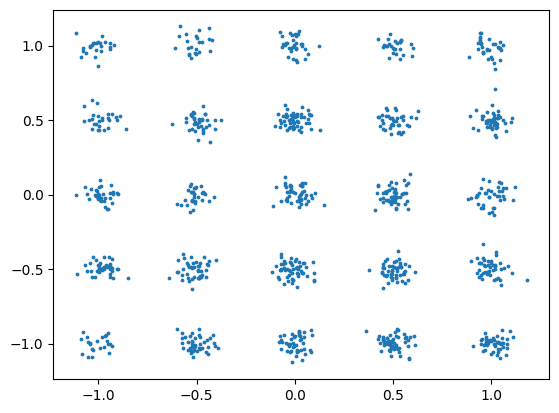

 84%|████████▍ | 84/100 [13:38<02:37,  9.84s/it]

Epoch 0 | Loss 6.642509
Epoch 49 | Loss 3.964881
Epoch 98 | Loss 5.813954


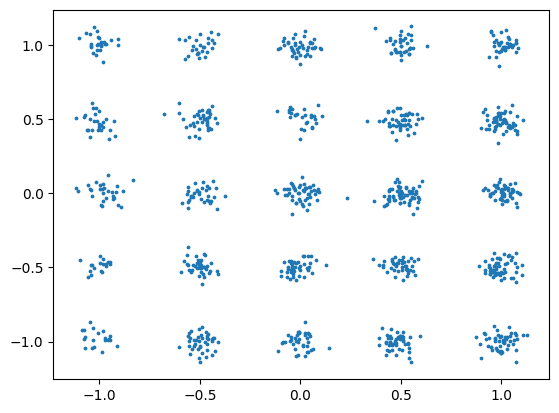

 85%|████████▌ | 85/100 [13:48<02:27,  9.85s/it]

Epoch 0 | Loss 9.039338
Epoch 49 | Loss 5.580320
Epoch 98 | Loss 4.263034


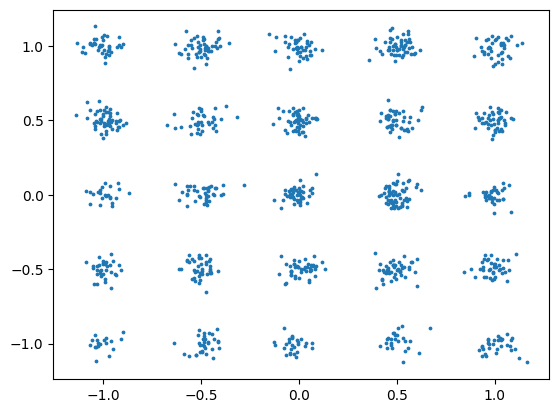

 86%|████████▌ | 86/100 [13:59<02:20, 10.02s/it]

Epoch 0 | Loss 5.694960
Epoch 49 | Loss 6.420997
Epoch 98 | Loss 15.032757


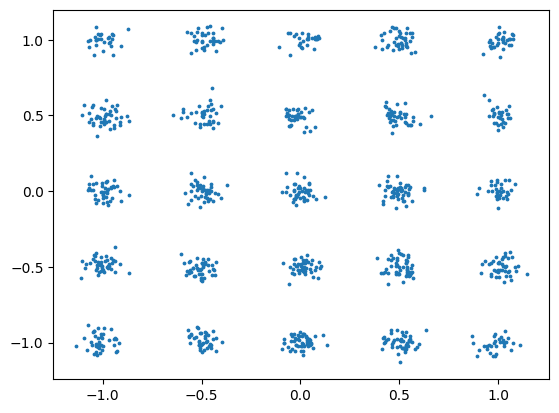

 87%|████████▋ | 87/100 [14:09<02:09,  9.98s/it]

Epoch 0 | Loss 7.995735
Epoch 49 | Loss 6.573753
Epoch 98 | Loss 5.451970


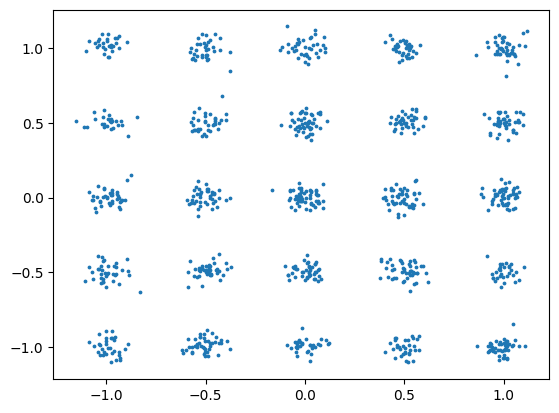

 88%|████████▊ | 88/100 [14:18<01:58,  9.89s/it]

Epoch 0 | Loss 5.168623
Epoch 49 | Loss 5.793863
Epoch 98 | Loss 5.442659


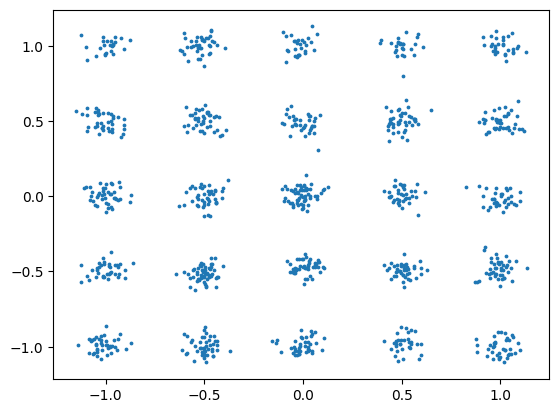

 89%|████████▉ | 89/100 [14:28<01:48,  9.84s/it]

Epoch 0 | Loss 4.652926


 89%|████████▉ | 89/100 [14:32<01:47,  9.80s/it]


KeyboardInterrupt: 

In [50]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)


            samples_high_t = samples[:batch_size//2]
            samples_low_t = samples[batch_size//2:]
            
            optimizer.zero_grad()

            t = torch.rand(len(samples)).to(device)
            t_high = t[:batch_size//2] * (1-t_switch_estimators) + t_switch_estimators
            t_low = t[batch_size//2:] * t_switch_estimators

            rm_loss_high_t = reward_matching_loss(estimate_grad_Rt_high_t,
                                                  model, 
                                                  full_gmm,
                                                  samples_high_t,
                                                  t_high, 
                                                  samples,
                                                  noise_schedule, 
                                                  num_mc_samples=num_mc_samples,
                                                  ) 
            
            rm_loss_low_t = reward_matching_loss(estimate_grad_Rt_low_t,
                                                  model, 
                                                  full_gmm,
                                                  samples_low_t,
                                                  t_low, 
                                                  samples,
                                                  noise_schedule, 
                                                  num_mc_samples=num_mc_samples,
                                                  )
            

            

            loss = rm_loss_high_t.mean() + rm_loss_low_t.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the network
    ve_reverse_sde = VEReverseSDE(model, noise_schedule)
    samples = generate_samples(ve_reverse_sde, 1000)
    samples_energy = full_gmm.log_prob(samples)

    # Update Buffer 
    buffer.add(samples, samples_energy)

    plt.scatter(samples.cpu()[:, 0], samples.cpu()[:, 1], s=3)
    plt.show()

    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(512 * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True)